I love college basketball. A lot. My beloved Marquette <strike>Golden Eagles</strike> Warriors are probably the only sports team that can really put me in agony.

Last season, I was watching a [nail-biter against Notre Dame](http://scores.espn.go.com/ncb/recap?gameId=330730269). With 3:36 left, Notre Dame's Jack Cooley grabbed an offensive board and promptly passed out to Pat Connaughton for a successful three-pointer. It was a dagger.

One thing stuck out to me though - after the shot, [Jay Bilas](http://en.wikipedia.org/wiki/Jay_Bilas), who was calling the game with [Bill Raftery](http://en.wikipedia.org/wiki/Bill_Raftery) and [Sean McDonough](http://en.wikipedia.org/wiki/Sean_McDonough), stated that the best time to attempt a 3-pointer is after an offensive rebound.

Intuitively, this statement makes sense - the defensive front line is crashing the boards in hopes of getting a rebound to end the offensive possession, while the defensive backcourt is out on the wings looking for an outlet pass from their teammates, likely leaving their offensive counterparts unguarded.

I've never seen any data that indicates whether three pointers are more successful after an offensive rebound though, much less whether it's the best time to shoot one. It seemed like something worth investigating.

In the following analysis, we'll try to determine whether there is a material difference between "normal" 3P% (those not shot after an offensive rebound) and 3P% when the shot was preceded by an offensive rebound.

I'll be going step by step through data collection, munging, and analysis.  If you're just interested in the answer, skip to the last section.

### Getting the data

ESPN has [play-by-play data](http://scores.espn.go.com/ncb/playbyplay?gameId=330620221) for almost every NCAA Division I game. I've written a python script that will collect all of this data for a given date range.  You can find the script [here](https://gist.github.com/gjreda/7175267). If you're unfamiliar with web scraping, [check out the tutorial](http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/) I wrote previously.

### Analysis

Here's an example of what the game files look like:

In [1]:
%cd ../../_code/cbb-play-data/

/Users/greda/Dropbox/gregreda.com/_code/cbb-play-data


In [2]:
!head -n 5 330620024.psv

In the output above, we see what a line referring to a three pointer looks like. Let's see what an offensive rebound line looks like:

In [3]:
!grep Offensive 330620024.psv | head -n 5

Now let's start our analysis using [pandas](http://pandas.pydata.org/).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

In [5]:
# read PSVs into DataFrame
games = []
files = glob.glob('*.psv')
for f in files:
    df = pd.read_csv(f, sep='|')
    df['game_id'] = f.replace('.psv', '')
    games.append(df)

print 'Read {0} games'.format(len(games))

Read 2931 games


To start, we need to find all incidents of a three pointer immediately after an offensive rebound.

This format is kind of crappy though - since events are in separate columns for the home and away teams, we'd have to write logic to check against each column.  Let's munge our data into a slightly different format - one column for `team`, which will indicate home/away, and another for `event`, which will store the description of what occurred.

In [6]:
games_df = pd.concat(games)

# add event_id to maintain event order
# we can use the index since pandas defaults to the Nth row of the file
games_df['event_id'] = games_df.index

# melt data into one column for home/away and another for event
# maintain play order by sorting on event_id
melted = pd.melt(games_df, id_vars=['event_id', 'game_id', 'time', 'score'],
                     var_name='team', value_name='event')
melted.sort_index(by=['game_id', 'event_id'], inplace=True)

# drop rows with NaN events - an event only belongs to one team
melted = melted[melted.event.notnull()]
print melted[10:15]

        event_id    game_id   time score  team                                  event
917522        10  330010066  19:11   0-0  home         Melvin Ejim missed Free Throw.
11            11  330010066  19:11   0-0  away  Jeremiah Kreisberg Defensive Rebound.
12            12  330010066  18:37   0-0  away            Justin Sears missed Jumper.
917525        13  330010066  18:37   0-0  home        Percy Gibson Defensive Rebound.
917526        14  330010066  18:31   0-0  home  Chris Babb missed Three Point Jumper.


We need to know whether the three pointers were missed or made - let's write a function called `get_shot_result` to extract the shot result from the `event` column. We can apply it to every row that contains a three pointer, storing the results in a new column called `shot_result`.

In [7]:
# label whether three pointers were made or missed
get_shot_result = lambda x: re.findall('(made|missed)', x)[0]
shot3 = melted.event.str.contains('Three Point')
melted['shot_result'] = melted[shot3].event.apply(get_shot_result)

Now let's write a function to label the events that meet our criteria - a three point attempt that was preceded by an offensive rebound. We can use `shift(1)` to reference the event on the previous row.

In [8]:
def criteria(df):
    """Labels if the three pointer was preceded by an offensive rebound."""
    df['after_oreb'] = ((df.event.str.contains('Three Point')) & \
                        df.event.shift(1).str.contains('Offensive Rebound'))
    df.after_oreb.fillna(False, inplace=True)
    return df

melted = melted.groupby('game_id').apply(criteria)
melted[melted.shot_result.notnull()].head(3)

,event_id,game_id,time,score,team,event,shot_result,after_oreb
2,2,330010066,19:31,0-0,away,Austin Morgan missed Three Point Jumper.,missed,False
917518,6,330010066,19:14,0-0,home,Will Clyburn missed Three Point Jumper.,missed,True
917526,14,330010066,18:31,0-0,home,Chris Babb missed Three Point Jumper.,missed,False


Finally, we can calculate the 3P% for our groups and plot the results.

In [9]:
threes = melted[melted.shot_result.notnull()]
attempts = threes.groupby(['shot_result', 'after_oreb']).size().unstack(0)
attempts['perc'] = attempts.made.astype(float) / (attempts.made + attempts.missed)
print attempts

shot_result   made  missed      perc
after_oreb                          
False        33244   63608  0.343245
True          2861    5341  0.348817


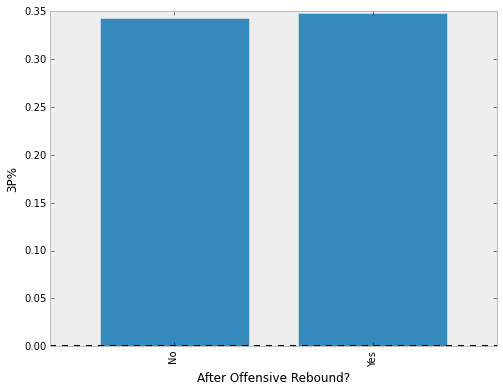

In [10]:
attempts.index = ['No', 'Yes']
plt.figure(figsize=[8, 6])
attempts.perc.plot(kind='bar')
plt.ylabel('3P%')
plt.xlabel('After Offensive Rebound?')
plt.grid(False);

### Digging deeper

At the most basic level, the difference is negligible. Not all post-offensive rebound three pointers are created equally though.  Let's investigate further to see whether three pointers shot shortly after the rebound are more successful.  Let's look at only three pointers that were shot within seven seconds of the offensive rebound.

To do so, we'll need to munge our data a bit more in order to calculate the seconds elapsed between rebound and shot attempt.

In [11]:
melted['minutes'] = melted.time.apply(lambda x: int(x.split(':')[0]))
melted['seconds'] = melted.time.apply(lambda x: int(x.split(':')[1]))

Notice below that time-outs and end of periods are duplicated within the data (this is because they originally appeared as both a home and away event).

In [12]:
duped_cols = ['game_id', 'event_id', 'time', 'event']
melted[melted.duplicated(cols=duped_cols)][:3]

,event_id,game_id,time,score,team,event,shot_result,after_oreb,minutes,seconds
917546,34,330010066,15:22,Official TV Timeout.,home,Official TV Timeout.,NaN,False,15,22
917559,47,330010066,13:40,Yale Full Timeout.,home,Yale Full Timeout.,NaN,False,13,40
917575,63,330010066,11:53,Official TV Timeout.,home,Official TV Timeout.,NaN,False,11,53


Let's get rid of them so we can easily label events within each period (keeping them in will throw our function off a bit).

In [13]:
melted.drop_duplicates(cols=['game_id', 'event_id', 'event'], inplace=True)

Now we can label each period based on when the `End of ...` event appears - events before it are the first half; events after, the second half. To do so, we can use `cumsum`, which will treat `True` values as 1.  This means we can just shift our results down a row and take the running total.

In [14]:
melted['period_end'] = melted.event.apply(lambda x: x.startswith('End of'))
melted[melted.period_end].head(3)

,event_id,game_id,time,score,team,event,shot_result,after_oreb,minutes,seconds,period_end
171,171,330010066,0:00,End of the 1st Half.,away,End of the 1st Half.,NaN,False,0,0,True
480,123,330010120,0:00,End of the 1st Half.,away,End of the 1st Half.,NaN,False,0,0,True
770,142,330010228,0:00,End of the 1st Half.,away,End of the 1st Half.,NaN,False,0,0,True


In [15]:
calculate_period = lambda x: x.shift(1).cumsum().fillna(0) + 1
melted['period'] = melted.groupby('game_id').period_end.apply(calculate_period)

Now we can use the period to calculate the total time left in the game.

In [16]:
melted.set_index('game_id', inplace=True)

# 40min regulation game + (# periods - 2 halves) * 5min OTs
gametime = lambda x: 40 + (x - 2) * 5
melted['gametime'] = melted.groupby(level=0).period.max().apply(gametime)
melted.reset_index('game_id', inplace=True)

Setting the `game_id` as the index was necessary for this function since pandas naturally tries to match on indexes. If we were to try ...
```
    melted['gametime'] = melted.groupby('game_id').period.max().apply(gametime)
```
It would not have worked because the Series object returned by our `groupby` operation uses the `game_id` as its index, while our DataFrame did not. pandas would have been unable to match the two and create the new `gametime` column.

In [17]:
melted.groupby('gametime').game_id.nunique()

gametime
35            54
40          2365
45           442
50            61
55             7
60             1
65             1
dtype: int64

Notice above that some games have a total gametime of 35 minutes. All college basketball games are at least 40 minutes, so something is off.

It turns out there are some inconsistencies in ESPN's play-by-play data - a couple games do not have the `End of the 1st Half.` event - [here's an example](http://scores.espn.go.com/ncb/playbyplay?gameId=330752617).  This throws off our `period` and `gametime` calculations. Such is life when dealing with scraped data though.

Let's keep things simple and just assume they were normal, non-OT games.

In [18]:
melted.loc[melted.gametime == 35, 'gametime'] = 40

Now let's normalize the event times to seconds left in the game. This will allow us to see how much time elapsed between the offensive rebound and three point attempt.

In [19]:
def clock_to_secs_left(df):
    """Calculates the total seconds left in the game."""
    df['secs_left'] = np.nan
    df.loc[df.period == 1, 'secs_left'] = (df.minutes * 60) + 1200 + df.seconds
    df.loc[df.period > 1, 'secs_left'] = (df.minutes * 60) + df.seconds
    return df

In [20]:
clock_to_secs_left(melted)
print melted[['game_id', 'time', 'event', 'period', 'secs_left']][:5]

     game_id   time                                     event period  secs_left
0  330010066  19:47                      Chris Babb Turnover.      1       2387
1  330010066  19:45                      Austin Morgan Steal.      1       2385
2  330010066  19:31  Austin Morgan missed Three Point Jumper.      1       2371
3  330010066  19:31          Korie Lucious Defensive Rebound.      1       2371
4  330010066  19:21              Korie Lucious missed Jumper.      1       2361


We can finally see how much time elapsed between offensive rebound and three point attempt.

We'll create a new field which will store the seconds elapsed since the previous event. Then we'll create a new DataFrame called `threes_after_orebs` which will hold three point attempts that were shot within seven seconds of an offensive rebound.

In [21]:
melted['secs_elapsed'] = melted.secs_left.shift(1) - melted.secs_left

mask = (melted.secs_elapsed >= 0) & (melted.secs_elapsed <= 7)
threes_after_orebs = melted[melted.after_oreb & mask]

Finally, let's group our data by the seconds elapsed and shot result to get the three point percentage for each bucket, which we can plot.

In [22]:
grouped = threes_after_orebs.groupby(['shot_result', 'secs_elapsed']).size()
grouped = grouped.unstack(0).fillna(0)

In [23]:
grouped['attempts'] = grouped.made + grouped.missed
grouped['percentage'] = grouped.made / grouped.attempts.astype(float)

In [24]:
t = threes.shot_result.value_counts()
t = float(t['made']) / (t['made'] + t['missed'])

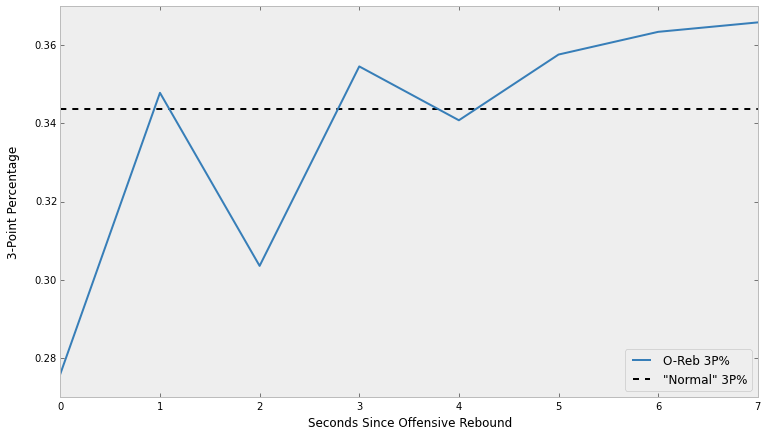

In [25]:
figsize(12.5, 7)

plt.plot(grouped.percentage, label='O-Reb 3P%', color='#377EB8')
plt.hlines(t, 0, 7, label='"Normal" 3P%', linestyles='--')
plt.xlabel('Seconds Since Offensive Rebound')
plt.xticks(np.arange(8))
plt.ylabel('3-Point Percentage', labelpad=15)
plt.grid(False)
plt.legend(loc='lower right');

It looks like there *might* be some truth to Jay Bilas' statement that the best time to shoot a three pointer is after an offensive rebound. However, we can go one step further and simulate our way to a numeric value of how "correct" he was.

### Simulations

To start, we'll create two Series based on the `melted` DataFrame that we have been using throughout the analysis. One Series, which we'll call `normal`, will hold the results of three pointers that were normally attempted - that is, they were not shot immediately after an offensive rebound.  The other Series, `after`, will contain the results of those shot after an offensive rebound.

`True` will be used to indicate a made basket.

In [26]:
convert = lambda x: True if x == 'made' else False

normal_criteria = (melted.after_oreb == False) & melted.shot_result.notnull()
normal = melted[normal_criteria].shot_result.apply(convert)

after_criteria = (melted.after_oreb) & melted.shot_result.notnull() & \
                    (melted.secs_elapsed <= 7)
after = melted[after_criteria].shot_result.apply(convert)

In [27]:
print "After O-Reb 3P%:", after.mean()
print "Sample Size:", len(after)
print "\n"
print "All other 3P%:", normal.mean()
print "Sample Size:", len(normal)
print "\n"
print "Absolute difference: %.4f" % (after.mean() - normal.mean())

After O-Reb 3P%: 0.350169109357
Sample Size: 4435


All other 3P%: 0.343264007931
Sample Size: 96838


Absolute difference: 0.0069


While we have data for 2,932 games, it turns out that three pointers shot within seven seconds of an offensive rebound aren't very common - it only occurred 4,435 times, while "normal" three pointers were shot 96,838 times.

The much smaller population means that we're more uncertain about the "true" success rate of those after offensive rebounds.

Using [pymc](http://pymc-devs.github.io/pymc/), we can run a simulations to determine how likely it is that three pointers after offensive rebounds really *are* easier, while taking into account this uncertainty.

We'll first assume a uniform distribution between 30% and 40% for both "normal" three pointers and those after offensive rebounds. This means that we believe the "true" success rate of each to be somewhere between 30-40%. This seems reasonable given that the 3P% for all of NCAA Division I basketball during the 2012-2013 season was 33.89% \[[source](http://statsheet.com/mcb/beyondthearc)].

We then generate observations using our `normal` and `after` Series. Our observations are an example of a Bernoulli distribution, meaning that the outcome is binary - the three pointer was either made (True) or missed (False).

We'll then run 20,000 simulations using our existing data and assumptions.

In [28]:
import pymc as pm

# no chance 3P% is out of this range
p_normal = pm.Uniform("p_normal", 0.3, 0.4)
p_after = pm.Uniform("p_after", 0.3, 0.4)

@pm.deterministic
def delta(p_normal=p_normal, p_after=p_after):
    return p_after - p_normal

# scraped observations
obs_normal = pm.Bernoulli("obs_normal", p_normal, value=normal, observed=True)
obs_after = pm.Bernoulli("obs_after", p_after, value=after, observed=True)

In [29]:
m = pm.MCMC([p_normal, p_after, delta, obs_normal, obs_after])
m.sample(20000)

 [-----------------100%-----------------] 20000 of 20000 complete in 35.4 sec

In [30]:
p_normal_samples = m.trace("p_normal")[:]
p_after_samples = m.trace("p_after")[:]
delta_samples = m.trace("delta")[:]

Finally, we can plot the results of our simulations.

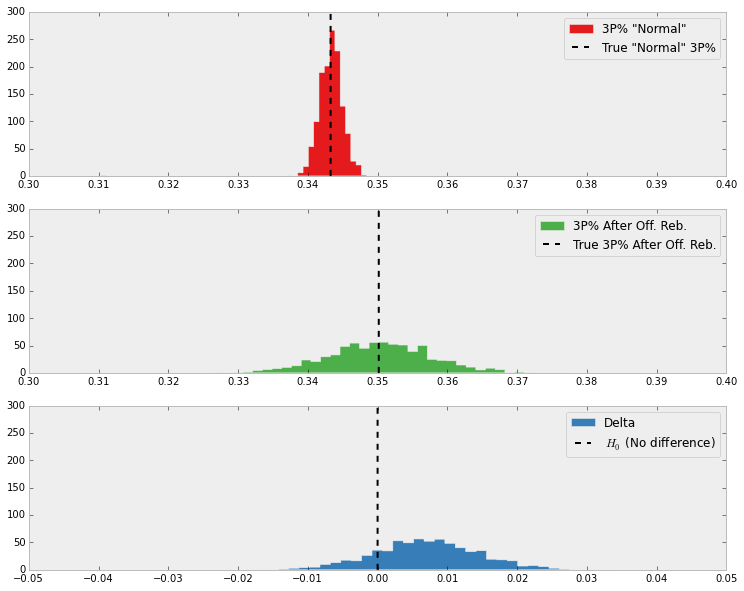

In [31]:
figsize(12.5, 10)

ax = plt.subplot(311)
plt.xlim(0.3, 0.4)
plt.xticks(np.arange(0.3, 0.401, 0.01))
plt.ylim(0, 300)
plt.hist(p_normal_samples, histtype='stepfilled', bins=50, normed=True, 
         color='#E41A1C', label='3P% "Normal"')
plt.vlines(normal.mean(), 0, 300, linestyles='--', label='True "Normal" 3P%')
plt.legend()
plt.grid(False)

ax = plt.subplot(312)
plt.xlim(0.3, 0.4)
plt.xticks(np.arange(0.3, 0.401, 0.01))
plt.ylim(0, 300)
plt.hist(p_after_samples, histtype='stepfilled', bins=50, normed=True,
         color='#4DAF4A', label='3P% After Off. Reb.')
plt.vlines(after.mean(), 0, 300, linestyles='--',
           label='True 3P% After Off. Reb.')
plt.legend()
plt.grid(False)

ax = plt.subplot(313)
plt.xlim(-0.05, 0.05)
plt.xticks(np.arange(-0.05, 0.051, 0.01))
plt.ylim(0, 300)
plt.hist(delta_samples, histtype='stepfilled', bins=50, normed=True,
         color='#377EB8', label='Delta')
plt.vlines(0, 0, 300, linestyles='--', label='$H_0$ (No difference)')
plt.legend()
plt.grid(False);

Notice the much narrower distribution at the top? This is because we had so many observations for "normal" three pointers. There wasn't much uncertainty! It's quite different than the second distribution, where the wider width of the distribution indicates are greater level of uncertainty on those attempted after offensive rebounds. This is due to the much smaller sample size.

The final distribution shows the difference between "normal" and "after" three pointers in our simulations. Much more often than not, "after" three pointers had a higher 3P% in the simulations.

In what percentage of simulations was "after" better than "normal" though?

In [32]:
print ("3P% after offensive rebounds was more successful "
       "in {0:.1f}% of simulations").format((delta_samples > 0).mean() * 100)

3P% after offensive rebounds was more successful in 83.1% of simulations


Looks like Jay Bilas is pretty right about this one. While the absolute difference in 3P% is small, those after an offensive rebound were more successful in about 83% of our simulations.